In [1]:
import pandas as pd
from IPython.display import display_html
import re
import os
import plotly.express as px
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ExpSineSquared, RationalQuadratic
from itertools import product
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import plotly.express as px
import plotly.graph_objects as go

# Read the Excel file (default reads the first sheet)
excel = pd.read_excel('2025_06_06_Charakterisierung_Hesse_Use_Case-Jupyter.xlsx')
#display(excel)

viskos = pd.read_csv('./viskos_means.csv', delimiter=";")
viskos.columns = ["DOE_NR", 'Viskos_500', 'Viskos_1000']
#display(viskos)

df_tr = pd.read_excel('./RunStatistic_train.xlsx', skiprows=8)
df_te = pd.read_excel('./RunStatistic_test.xlsx', skiprows=3)
#display(df_tr)
#display(df_te)

In [2]:
columns = ["DOE_NR","Run_ID","Experiment",               
                 "Basis", "Matt_Beads", "Matt_Silica", "Wachs", "Verdicker",
                 "Time_To_Mix", "Time_To_Dispense", # time from Dispsene until mix & time from Mix to drawdown
                "thickness", # thickness
                "gloss_60", "gloss_85", #"haze", # Gloss / Haze
                "L", #Spektrum
                "Kratzfestigkeit" ]
df_train = pd.DataFrame(columns=columns)
i = 0
for run_id in df_tr["Run ID"].unique():
    df_temp_run = df_tr[df_tr["Run ID"] == run_id]
    for exp_id in df_temp_run["Experiment"].unique():
        df_temp_exp = df_temp_run[df_temp_run["Experiment"] == exp_id]
        df_temp = df_temp_exp
        exp_id = exp_id.split(" ")[1]
        df_temp["Experiment"] == exp_id
        i += 1
        # extract dispensed values
        value1 = df_temp[df_temp['Dispense Material'] == 'I2Dach_Hesse_Basismodul ']['Dispensed Amount'].iloc[0]
        value2 = df_temp[df_temp['Dispense Material'] == 'I2Dach_Hesse_Mattmodul Beads HM 9-007']['Dispensed Amount'].iloc[0]
        value3 = df_temp[df_temp['Dispense Material'] == 'I2Dach_Hesse_Mattmodul Silica HM 9-008']['Dispensed Amount'].iloc[0]
        value4 = df_temp[df_temp['Dispense Material'] == 'I2Dach_Hesse_Wachsmodul HM 7-004']['Dispensed Amount'].iloc[0]
        value5 = df_temp[df_temp['Dispense Material'] == 'I2Dach_Hesse_Verdickermodul HZ 3-88']['Dispensed Amount'].iloc[0]

        # Calculate the time until mix
        timestamp_dispense = pd.to_datetime(df_temp[df_temp['Node'] == '3996: Dispense Liquid - M']['Started (UTC)'].iloc[0])
        timestamp_mix = pd.to_datetime(df_temp[df_temp['Node'] == '3999: Mix']['Started (UTC)'].iloc[0])
        time_to_mix = timestamp_mix - timestamp_dispense
        
        # Calculate the time from mix to dispense
        timestamp_drawdown = pd.to_datetime(df_temp[df_temp['Node'] == '4001: Draw Down']['Started (UTC)'].iloc[0])
        time_to_drawdown = timestamp_drawdown - timestamp_mix

        ### Abrasion
        new_row = pd.DataFrame({"DOE_NR": f"DOE-{i}","Run_ID": run_id,"Experiment": exp_id,
                                "Basis": value1, "Matt_Beads": value2, "Matt_Silica": value3, "Wachs": value4, "Verdicker": value5,
                                "Time_To_Mix": time_to_mix.total_seconds(), "Time_To_Dispense": time_to_drawdown.total_seconds(),
                                "thickness": excel.loc[i-1, 'Schichtdicke'],
                                "gloss_60": excel.loc[i-1, 'Glanz Winkel 60°'], "gloss_85": excel.loc[i-1, 'Glanz Winkel 85°'], # "haze": haze,
                                "L": excel.loc[i-1, 'Deckvermögen (L)'],
                                "Kratzfestigkeit": excel.loc[i-1, 'Kratzfestigkeit']
                                }, index=[0])
        df_train = pd.concat([df_train, new_row], ignore_index=True)

        ### Rheologie
df_train = pd.merge(df_train, viskos)
df_train

/tmp/ipykernel_471585/2714870249.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_train = pd.concat([df_train, new_row], ignore_index=True)


,DOE_NR,Run_ID,Experiment,Basis,Matt_Beads,Matt_Silica,Wachs,Verdicker,Time_To_Mix,Time_To_Dispense,thickness,gloss_60,gloss_85,L,Kratzfestigkeit,Viskos_500,Viskos_1000
0,DOE-1,1056,1,99.988,0.000,0.000,0.000,0.000,828.0,315.0,31.32,82.2,97.6,4.36,1.800000,233.6690,146.6440
1,DOE-2,1056,2,85.484,4.988,5.023,1.991,2.514,1075.0,319.0,34.80,11.6,21.7,11.82,1.133333,603.3600,322.8130
2,DOE-3,1056,3,82.754,3.750,11.263,0.993,1.254,2370.0,325.0,34.68,7.0,15.1,14.99,0.566667,192.7770,117.5220
3,DOE-4,1056,4,88.238,3.762,1.263,2.993,3.758,1105.0,321.0,36.24,22.6,39.2,8.86,2.966667,979.0620,507.4410
4,DOE-5,1056,5,87.911,6.546,0.942,1.494,3.136,1039.0,319.0,32.28,21.2,36.1,9.47,2.666667,855.2670,439.0990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,DOE-60,1061,10,84.574,4.518,3.305,2.726,4.933,937.0,359.0,36.56,13.4,24.8,11.29,1.766667,1159.1200,594.2810
60,DOE-61,1063,1,91.444,3.740,1.602,0.204,3.061,752.0,387.0,36.24,30.8,50.5,7.51,1.866667,866.8360,446.9230
61,DOE-62,1063,2,81.936,3.114,12.185,2.226,0.563,735.0,408.0,30.72,6.2,15.1,16.21,0.733333,64.1512,49.0348
62,DOE-63,1063,3,84.188,9.829,0.481,1.211,4.317,701.0,325.0,35.20,15.3,25.9,11.83,1.600000,1087.7200,560.9710


In [3]:
columns = ["DOE_NR","Run_ID","Experiment",               
                 "Basis", "Matt_Beads", "Matt_Silica", "Wachs", "Verdicker",
                 "Time_To_Mix", "Time_To_Dispense", # time from Dispsene until mix & time from Mix to drawdown
                "thickness", # thickness
                "gloss_60", "gloss_85", #"haze", # Gloss / Haze
                "L", #Spektrum
                "Kratzfestigkeit" ]
df_test = pd.DataFrame(columns=columns)
i = 0
i = 0
for run_id in df_te["Run ID"].unique():
    df_temp_run = df_te[df_te["Run ID"] == run_id]
    for exp_id in df_temp_run["Experiment"].unique():
        df_temp_exp = df_temp_run[df_temp_run["Experiment"] == exp_id]
        df_temp = df_temp_exp
        exp_id = exp_id.split(" ")[1]
        df_temp["Experiment"] == exp_id
        i += 1
        # extract dispensed values
        value1 = df_temp[df_temp['Dispense Material'] == 'I2Dach_Hesse_Basismodul ']['Dispensed Amount'].iloc[0]
        value2 = df_temp[df_temp['Dispense Material'] == 'I2Dach_Hesse_Mattmodul Beads HM 9-007']['Dispensed Amount'].iloc[0]
        value3 = df_temp[df_temp['Dispense Material'] == 'I2Dach_Hesse_Mattmodul Silica HM 9-008']['Dispensed Amount'].iloc[0]
        value4 = df_temp[df_temp['Dispense Material'] == 'I2Dach_Hesse_Wachsmodul HM 7-004']['Dispensed Amount'].iloc[0]
        value5 = df_temp[df_temp['Dispense Material'] == 'I2Dach_Hesse_Verdickermodul HZ 3-88']['Dispensed Amount'].iloc[0]

        # Calculate the time until mix
        timestamp_dispense = pd.to_datetime(df_temp[df_temp['Node'] == '3996: Dispense Liquid - M']['Started (UTC)'].iloc[0])
        timestamp_mix = pd.to_datetime(df_temp[df_temp['Node'] == '3999: Mix']['Started (UTC)'].iloc[0])
        time_to_mix = timestamp_mix - timestamp_dispense
        
        # Calculate the time from mix to dispense
        timestamp_drawdown = pd.to_datetime(df_temp[df_temp['Node'] == '4001: Draw Down']['Started (UTC)'].iloc[0])
        time_to_drawdown = timestamp_drawdown - timestamp_mix

        ### Abrasion
        new_row = pd.DataFrame({"DOE_NR": f"TEST-{i}","Run_ID": run_id,"Experiment": exp_id,
                                "Basis": value1, "Matt_Beads": value2, "Matt_Silica": value3, "Wachs": value4, "Verdicker": value5,
                                "Time_To_Mix": time_to_mix.total_seconds(), "Time_To_Dispense": time_to_drawdown.total_seconds(),
                                "thickness": excel.loc[i-1, 'Schichtdicke'],
                                "gloss_60": excel.loc[i-1, 'Glanz Winkel 60°'], "gloss_85": excel.loc[i-1, 'Glanz Winkel 85°'], # "haze": haze,
                                "L": excel.loc[i-1, 'Deckvermögen (L)'],
                                "Kratzfestigkeit": excel.loc[i-1, 'Kratzfestigkeit']
                                }, index=[0])
        df_test = pd.concat([df_test, new_row], ignore_index=True)
df_test = pd.merge(df_test, viskos)
df_test

/tmp/ipykernel_471585/3407986493.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test = pd.concat([df_test, new_row], ignore_index=True)


,DOE_NR,Run_ID,Experiment,Basis,Matt_Beads,Matt_Silica,Wachs,Verdicker,Time_To_Mix,Time_To_Dispense,thickness,gloss_60,gloss_85,L,Kratzfestigkeit,Viskos_500,Viskos_1000
0,TEST-1,1064,1,86.790,3.519,2.744,2.264,4.706,740.0,337.0,31.32,82.2,97.6,4.36,1.800000,1096.780,558.817
1,TEST-2,1064,2,90.940,0.539,0.711,3.773,4.062,678.0,352.0,34.80,11.6,21.7,11.82,1.133333,1001.465,518.929
2,TEST-3,1064,3,84.701,10.544,0.702,1.272,2.831,710.0,325.0,34.68,7.0,15.1,14.99,0.566667,769.346,404.048
3,TEST-4,1064,4,80.061,11.190,5.084,2.779,0.967,712.0,354.0,36.24,22.6,39.2,8.86,2.966667,300.107,172.284
4,TEST-5,1065,1,82.043,2.599,11.179,0.775,3.456,736.0,473.0,32.28,21.2,36.1,9.47,2.666667,592.098,308.359
5,TEST-6,1065,2,87.943,2.741,6.012,1.758,1.566,716.0,358.0,33.76,4.5,10.8,18.68,0.466667,387.251,214.232
6,TEST-7,1065,3,77.696,15.238,3.505,3.265,0.318,742.0,351.0,34.08,9.2,16.5,12.98,1.566667,215.734,132.135
7,TEST-8,1065,4,93.811,0.213,3.520,0.272,2.204,722.0,333.0,40.52,31.7,53.7,6.99,2.600000,588.807,311.722


In [4]:
# Define the features and targets
features = ["Matt_Beads", "Matt_Silica", "Wachs", "Verdicker", "Time_To_Mix", "Time_To_Dispense", "L", "thickness"]
targets = ["gloss_60", "gloss_85",  "Viskos_500", "Viskos_1000",'Kratzfestigkeit']

# Calculate the sum of the selected columns
column_sum = df_train[["Basis", "Matt_Beads", "Matt_Silica", "Wachs", "Verdicker"]].sum(axis=1)
df_train["Matt_Sum"] = df_train["Matt_Beads"] + df_train["Matt_Silica"]
df_train["Matt_Ratio"] = df_train["Matt_Beads"] / df_train["Matt_Sum"]

# test
column_sum = df_test[["Basis", "Matt_Beads", "Matt_Silica", "Wachs", "Verdicker"]].sum(axis=1)
df_test["Matt_Sum"] = df_test["Matt_Beads"] + df_test["Matt_Silica"]
df_test["Matt_Ratio"] = df_test["Matt_Beads"] / df_test["Matt_Sum"]

# Drop columns & merge
all_data = pd.concat([df_train.drop(columns=["DOE_NR","Run_ID", "Experiment", "Basis"]), df_test.drop(columns=["DOE_NR","Run_ID", "Experiment", "Basis"])])

all_data.fillna(0, inplace=True)
all_data = all_data[['Matt_Beads', 'Matt_Silica', 'Wachs', 'Verdicker', 'Matt_Sum','Matt_Ratio', 'Time_To_Mix', 'Time_To_Dispense', 'thickness', 'L',
       'gloss_60', 'gloss_85', 'Kratzfestigkeit', 'Viskos_500', 'Viskos_1000', ]]
all_data.reset_index(inplace=True)
all_data['split'] = ['train'] * 64 + ['test'] * 8
all_data.drop(columns=["index"], inplace=True)
all_data.tail(8)

,Matt_Beads,Matt_Silica,Wachs,Verdicker,Matt_Sum,Matt_Ratio,Time_To_Mix,Time_To_Dispense,thickness,L,gloss_60,gloss_85,Kratzfestigkeit,Viskos_500,Viskos_1000,split
64,3.519,2.744,2.264,4.706,6.263,0.561871,740.0,337.0,31.32,4.36,82.2,97.6,1.800000,1096.780,558.817,test
65,0.539,0.711,3.773,4.062,1.250,0.431200,678.0,352.0,34.80,11.82,11.6,21.7,1.133333,1001.465,518.929,test
66,10.544,0.702,1.272,2.831,11.246,0.937578,710.0,325.0,34.68,14.99,7.0,15.1,0.566667,769.346,404.048,test
67,11.190,5.084,2.779,0.967,16.274,0.687600,712.0,354.0,36.24,8.86,22.6,39.2,2.966667,300.107,172.284,test
68,2.599,11.179,0.775,3.456,13.778,0.188634,736.0,473.0,32.28,9.47,21.2,36.1,2.666667,592.098,308.359,test
69,2.741,6.012,1.758,1.566,8.753,0.313150,716.0,358.0,33.76,18.68,4.5,10.8,0.466667,387.251,214.232,test
70,15.238,3.505,3.265,0.318,18.743,0.812997,742.0,351.0,34.08,12.98,9.2,16.5,1.566667,215.734,132.135,test
71,0.213,3.520,0.272,2.204,3.733,0.057059,722.0,333.0,40.52,6.99,31.7,53.7,2.600000,588.807,311.722,test


In [5]:
all_data.to_csv("DoE_data.csv")

# Correlation

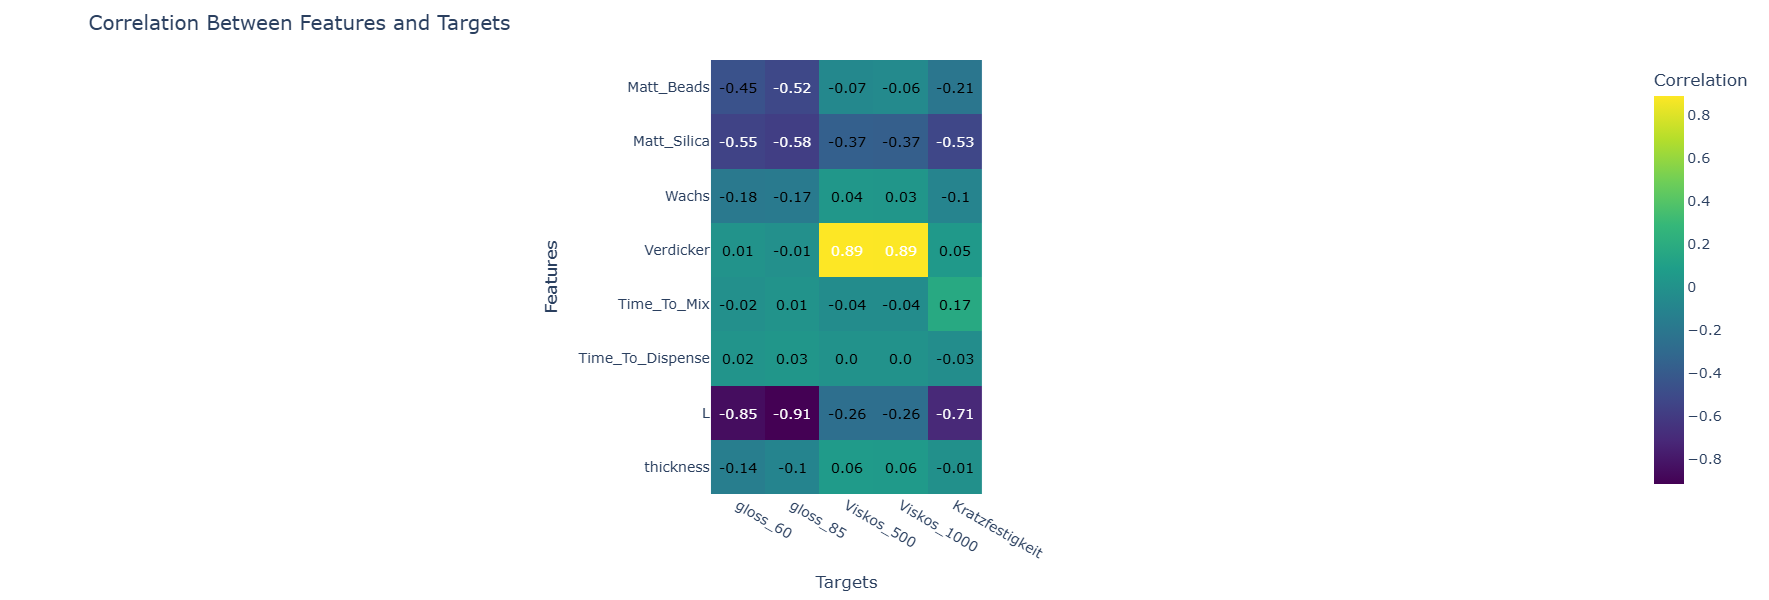

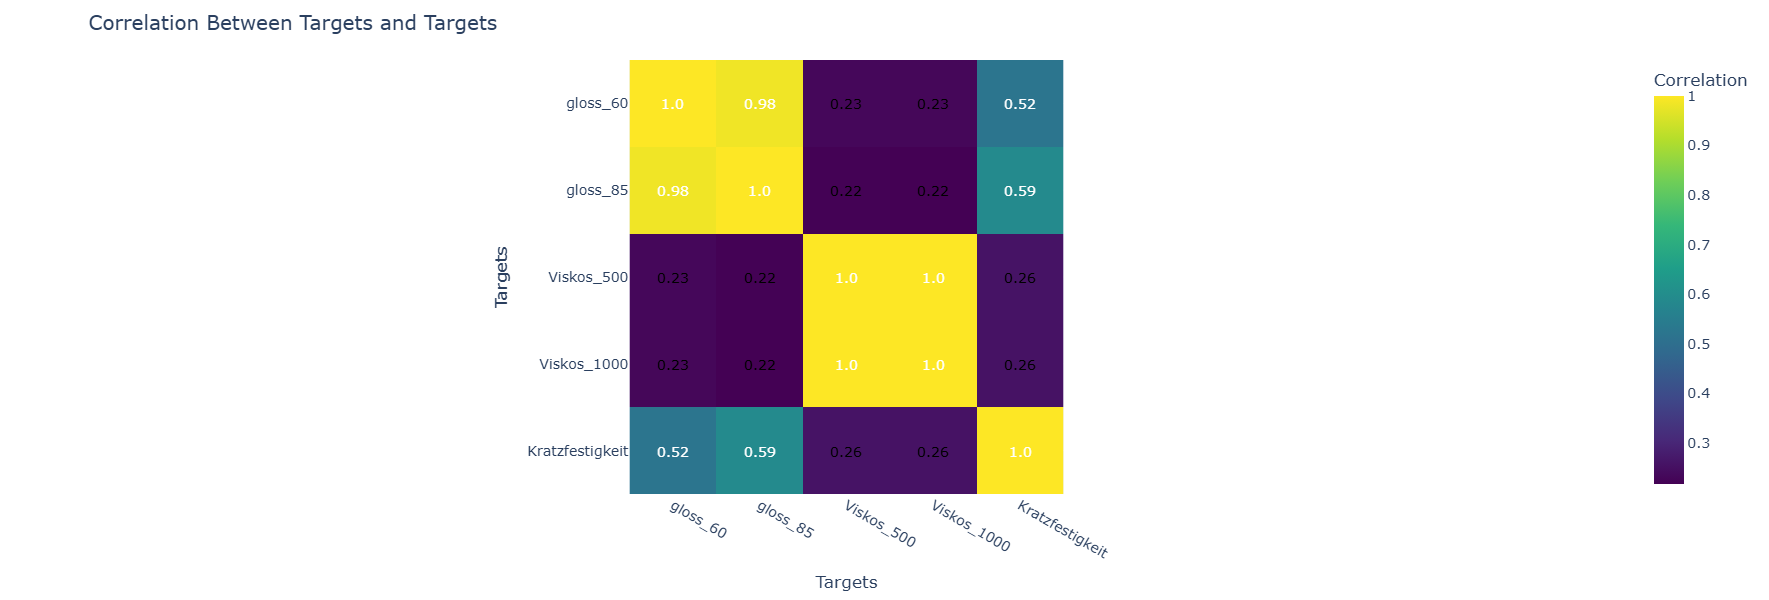

In [6]:
df = all_data.copy()
df.drop(columns=["split"], inplace=True)
correlation_matrix = df.corr()

# Extract the correlation between features and targets
feature_target_correlation = correlation_matrix.loc[features, targets]

# Create a heatmap to visualize the correlation
fig = px.imshow(feature_target_correlation, color_continuous_scale='Viridis')
fig.update_layout(
    title="Correlation Between Features and Targets",
    xaxis_title="Targets",
    yaxis_title="Features",
    width=800,  # adjust width of the plot
    height=600,  # adjust height of the plot
    font=dict(size=14),  # adjust font size
    annotations=[dict(x=x, y=y, text=str(round(value, 2)),
                      showarrow=False, font=dict(color='white' if abs(value) > 0.5 else 'black'))
                 for x in range(len(targets))
                 for y in range(len(features))
                 for value in [feature_target_correlation.iloc[y, x]]],
    coloraxis_colorbar=dict(title="Correlation")  # add colorbar title
)
fig.show()

# Extract the correlation between features and targets
feature_target_correlation = correlation_matrix.loc[targets, targets]

# Create a heatmap to visualize the correlation
fig = px.imshow(feature_target_correlation, color_continuous_scale='Viridis')
fig.update_layout(
    title="Correlation Between Targets and Targets",
    xaxis_title="Targets",
    yaxis_title="Targets",
    width=800,  # adjust width of the plot
    height=600,  # adjust height of the plot
    font=dict(size=14),  # adjust font size
    annotations=[dict(x=x, y=y, text=str(round(value, 2)),
                      showarrow=False, font=dict(color='white' if abs(value) > 0.5 else 'black'))
                 for x in range(len(targets))
                 for y in range(len(targets))
                 for value in [feature_target_correlation.iloc[y, x]]],
    coloraxis_colorbar=dict(title="Correlation")  # add colorbar title
)
fig.show()

# ML on original data

### Preprocessing

In [7]:
# Assuming df_train_1 and df_test_1 are your DataFrames with the data
selected_train_columns = ["Matt_Beads", "Matt_Silica", 'Wachs', 'Verdicker',  #"Matt_Sum", "Matt_Ratio",
                          'Time_To_Mix', 'Time_To_Dispense', 'thickness',  "L"]
selected_target_columns = [ 'gloss_85',  'Viskos_500', "Kratzfestigkeit"]
df_train = all_data[all_data["split"] == "train"]
df_test = all_data[all_data["split"] == "test"]
display(df_train)
display(df_test)
X_train = np.array(df_train[selected_train_columns])
y_train = np.array(df_train[selected_target_columns])
X_test = np.array(df_test[selected_train_columns])
y_test = np.array(df_test[selected_target_columns])

scaler = MinMaxScaler((0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

,Matt_Beads,Matt_Silica,Wachs,Verdicker,Matt_Sum,Matt_Ratio,Time_To_Mix,Time_To_Dispense,thickness,L,gloss_60,gloss_85,Kratzfestigkeit,Viskos_500,Viskos_1000,split
0,0.000,0.000,0.000,0.000,0.000,0.000000,828.0,315.0,31.32,4.36,82.2,97.6,1.800000,233.6690,146.6440,train
1,4.988,5.023,1.991,2.514,10.011,0.498252,1075.0,319.0,34.80,11.82,11.6,21.7,1.133333,603.3600,322.8130,train
2,3.750,11.263,0.993,1.254,15.013,0.249784,2370.0,325.0,34.68,14.99,7.0,15.1,0.566667,192.7770,117.5220,train
3,3.762,1.263,2.993,3.758,5.025,0.748657,1105.0,321.0,36.24,8.86,22.6,39.2,2.966667,979.0620,507.4410,train
4,6.546,0.942,1.494,3.136,7.488,0.874199,1039.0,319.0,32.28,9.47,21.2,36.1,2.666667,855.2670,439.0990,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,4.518,3.305,2.726,4.933,7.823,0.577528,937.0,359.0,36.56,11.29,13.4,24.8,1.766667,1159.1200,594.2810,train
60,3.740,1.602,0.204,3.061,5.342,0.700112,752.0,387.0,36.24,7.51,30.8,50.5,1.866667,866.8360,446.9230,train
61,3.114,12.185,2.226,0.563,15.299,0.203543,735.0,408.0,30.72,16.21,6.2,15.1,0.733333,64.1512,49.0348,train
62,9.829,0.481,1.211,4.317,10.310,0.953346,701.0,325.0,35.20,11.83,15.3,25.9,1.600000,1087.7200,560.9710,train


,Matt_Beads,Matt_Silica,Wachs,Verdicker,Matt_Sum,Matt_Ratio,Time_To_Mix,Time_To_Dispense,thickness,L,gloss_60,gloss_85,Kratzfestigkeit,Viskos_500,Viskos_1000,split
64,3.519,2.744,2.264,4.706,6.263,0.561871,740.0,337.0,31.32,4.36,82.2,97.6,1.800000,1096.780,558.817,test
65,0.539,0.711,3.773,4.062,1.250,0.431200,678.0,352.0,34.80,11.82,11.6,21.7,1.133333,1001.465,518.929,test
66,10.544,0.702,1.272,2.831,11.246,0.937578,710.0,325.0,34.68,14.99,7.0,15.1,0.566667,769.346,404.048,test
67,11.190,5.084,2.779,0.967,16.274,0.687600,712.0,354.0,36.24,8.86,22.6,39.2,2.966667,300.107,172.284,test
68,2.599,11.179,0.775,3.456,13.778,0.188634,736.0,473.0,32.28,9.47,21.2,36.1,2.666667,592.098,308.359,test
69,2.741,6.012,1.758,1.566,8.753,0.313150,716.0,358.0,33.76,18.68,4.5,10.8,0.466667,387.251,214.232,test
70,15.238,3.505,3.265,0.318,18.743,0.812997,742.0,351.0,34.08,12.98,9.2,16.5,1.566667,215.734,132.135,test
71,0.213,3.520,0.272,2.204,3.733,0.057059,722.0,333.0,40.52,6.99,31.7,53.7,2.600000,588.807,311.722,test


(64, 8) (64, 3) (8, 8) (8, 3)


### Single Output Modeling

In [8]:
# ==== Model training ====
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10]
}

individual_models = {}
y_pred_list = []
per_target_metrics = []

for i, target in enumerate(selected_target_columns):
    print(f"\nTraining model for target: {target}")

    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train[:, i])

    best_model = grid_search.best_estimator_
    individual_models[target] = best_model

    # Predictions in original scale
    y_pred_target = best_model.predict(X_test_scaled).reshape(-1, 1)
    y_pred_list.append(y_pred_target)

    # Metrics (original scale)
    mse = mean_squared_error(y_test[:, i], y_pred_target)
    mae = mean_absolute_error(y_test[:, i], y_pred_target)
    mae_mean_ratio = mae / np.mean(np.abs(y_test[:, i]))
    r2 = r2_score(y_test[:, i], y_pred_target)

    per_target_metrics.append({
        'Target': target,
        'MSE': mse,
        'MAE': mae,
        'MAE/Mean': mae_mean_ratio,
        'R2': r2
    })

# ==== Predictions combined ====
y_pred = np.hstack(y_pred_list)

# ==== Metrics table ====
print("\n=== Per-Target Metrics (Original Scale) ===")
per_target_df = pd.DataFrame(per_target_metrics)
display(per_target_df)


Training model for target: gloss_85

Training model for target: Viskos_500

Training model for target: Kratzfestigkeit

=== Per-Target Metrics (Original Scale) ===


,Target,MSE,MAE,MAE/Mean,R2
0,gloss_85,110.104566,5.177000,0.142470,0.847442
1,Viskos_500,1815.396975,34.132494,0.055146,0.979739
2,Kratzfestigkeit,0.610578,0.597616,0.347283,0.248504


### MultiOutputModeling

In [9]:
from sklearn.multioutput import MultiOutputRegressor
# ==== Define hyperparameter grid ====
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [3, 5, 10, None],
    'estimator__min_samples_split': [2, 5, 10]
}

# ==== Multi-Output Regressor Setup ====
rf = RandomForestRegressor()
multi_output_rf = MultiOutputRegressor(rf)

# ==== Grid Search ====
grid_search = GridSearchCV(
    estimator=multi_output_rf,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

# ==== Fit ====
grid_search.fit(X_train_scaled, y_train)  # y in original scale

# Best model
best_multi_model = grid_search.best_estimator_

# ==== Predict ====
y_pred = best_multi_model.predict(X_test_scaled)

# ==== Per-Target Evaluation (Original Scale) ====
print("\n=== Per-Target Metrics (Original Scale) ===")
per_target_metrics = []

for i, target in enumerate(selected_target_columns):
    y_true = y_test[:, i]
    y_p = y_pred[:, i]

    mse_t = mean_squared_error(y_true, y_p)
    mae_t = mean_absolute_error(y_true, y_p)
    mae_mean_ratio_t = mae_t / np.mean(np.abs(y_true))
    r2_t = r2_score(y_true, y_p)

    per_target_metrics.append({
        'Target': target,
        'MSE': mse_t,
        'MAE': mae_t,
        'MAE/Mean': mae_mean_ratio_t,
        'R2': r2_t
    })

per_target_df = pd.DataFrame(per_target_metrics)
display(per_target_df)


=== Per-Target Metrics (Original Scale) ===


,Target,MSE,MAE,MAE/Mean,R2
0,gloss_85,102.717481,5.515293,0.151780,0.857677
1,Viskos_500,3021.529214,48.154751,0.077801,0.966278
2,Kratzfestigkeit,0.617669,0.613870,0.356728,0.239775


### logtransform

Matt_Beads         -0.261510
Matt_Silica        -0.661132
Wachs              -0.084619
Verdicker           0.075278
Matt_Sum           -0.698100
Matt_Ratio          0.208277
Time_To_Mix         0.228976
Time_To_Dispense   -0.058093
thickness          -0.051098
L                  -0.708826
gloss_60            0.555458
gloss_85            0.612485
Kratzfestigkeit     1.000000
Viskos_500          0.339007
Viskos_1000         0.339071
Name: Kratzfestigkeit, dtype: float64
Matt_Beads         -0.246135
Matt_Silica        -0.667377
Wachs              -0.112065
Verdicker           0.073305
Matt_Sum           -0.626477
Matt_Ratio          0.238292
Time_To_Mix         0.231252
Time_To_Dispense   -0.013103
thickness          -0.059237
L                  -0.709046
gloss_60            0.724674
gloss_85            0.713965
Kratzfestigkeit     1.000000
Viskos_500          0.362830
Viskos_1000         0.366359
Name: Kratzfestigkeit, dtype: float64


<Axes: >

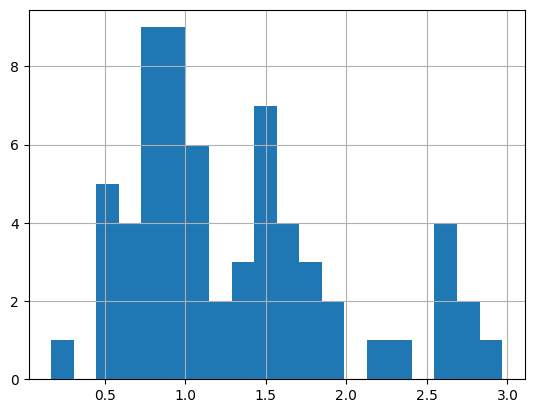

In [10]:
print(df_train.drop(columns=["split"]).corr()["Kratzfestigkeit"])
print(np.log1p(df_train.drop(columns=["split"])).corr()["Kratzfestigkeit"])
df_train["Kratzfestigkeit"].hist(bins=20)

In [11]:
# === Apply log-transform to targets ===
y_train_log = np.log1p(np.array(df_train[selected_target_columns]))
y_test_log = np.log1p(np.array(df_test[selected_target_columns]))

# --- Train One Optimized Regressor Per Target ---
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10]
}

individual_models = {}
y_pred_log_list = []
per_target_metrics_original = []

for i, target in enumerate(selected_target_columns):
    print(f"\nTraining model for target: {target}")

    rf = RandomForestRegressor()
    grid_search = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, scoring="neg_mean_squared_error")
    grid_search.fit(X_train_scaled, y_train_log[:, i])

    best_model = grid_search.best_estimator_
    individual_models[target] = best_model

    # Predict in log-space
    y_pred_log = best_model.predict(X_test_scaled).reshape(-1, 1)
    y_pred_log_list.append(y_pred_log)

    # Back-transform to original target scale
    y_pred_original = np.expm1(y_pred_log).flatten()
    y_true_original = np.expm1(y_test_log[:, i]).flatten()

    # Metrics (original scale)
    mse_orig = mean_squared_error(y_true_original, y_pred_original)
    mae_orig = mean_absolute_error(y_true_original, y_pred_original)
    mae_mean_ratio_orig = mae_orig / np.mean(np.abs(y_true_original))
    r2_orig = r2_score(y_true_original, y_pred_original)

    per_target_metrics_original.append({
        "Target": target,
        "MSE": mse_orig,
        "MAE": mae_orig,
        "MAE/Mean": mae_mean_ratio_orig,
        "R2": r2_orig
    })

# === Combine all predictions (original scale) ===
y_pred_original_all = np.hstack([
    np.expm1(pred) for pred in y_pred_log_list
])
y_true_original_all = np.expm1(y_test_log)

# === Output metrics ===
print("\n=== Per-Target Metrics (Original Scale) ===")
per_target_df_orig = pd.DataFrame(per_target_metrics_original)
display(per_target_df_orig)


Training model for target: gloss_85

Training model for target: Viskos_500

Training model for target: Kratzfestigkeit

=== Per-Target Metrics (Original Scale) ===


,Target,MSE,MAE,MAE/Mean,R2
0,gloss_85,141.356891,5.665531,0.155914,0.804140
1,Viskos_500,4584.256371,54.608989,0.088229,0.948838
2,Kratzfestigkeit,0.742535,0.667928,0.388142,0.086091


## Insights

- **Single-output modeling** is most effective.
- **Gloss** and **Viskos_500** are already well-fitted — **Kratzfestigkeit** needs more attention.
- **Log transform** is unnecessary for `Kratzfestigkeit` and is likely hurting performance becablurs.


# Compare different Feature Configurations

In [12]:
# ==== Feature set configurations ====
feature_sets = {
    "Config 1": ["Matt_Beads", "Matt_Silica", 'Wachs', 'Verdicker'],
    "Config 2": ["Matt_Beads", "Matt_Silica", 'Wachs', 'Verdicker', 'Time_To_Mix', 'Time_To_Dispense', 'thickness', "L"],
    "Config 3": ["Matt_Sum", "Matt_Ratio", 'Wachs', 'Verdicker'],
    "Config 4": ["Matt_Sum", "Matt_Ratio", 'Wachs', 'Verdicker','Time_To_Mix', 'Time_To_Dispense', 'thickness', "L"]
}

n_trials = 100
all_results = []

# ===== Step 1: Get best parameters for each config =====
best_params_per_config = {}

for config_name, selected_train_columns in feature_sets.items():
    print(f"\n=== Finding best params for {config_name} ===")
    X_train = np.array(df_train[selected_train_columns])
    y_train = np.array(df_train[selected_target_columns])
    
    # Scale features
    scaler = MinMaxScaler((0, 1))
    X_train_scaled = scaler.fit_transform(X_train)
    
    # We'll pick params based on gloss_85 (target 0) only
    rf = RandomForestRegressor()
    gs = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
    gs.fit(X_train_scaled, y_train[:, 0])
    
    best_params_per_config[config_name] = gs.best_params_
    print(f"  Best params: {gs.best_params_}")

# ===== Step 2: Average over 100 trials with fixed params =====
for config_name, selected_train_columns in feature_sets.items():
    print(f"\n=== Running trials for {config_name} ===")
    params = best_params_per_config[config_name]
    
    X_train = np.array(df_train[selected_train_columns])
    y_train = np.array(df_train[selected_target_columns])
    X_test = np.array(df_test[selected_train_columns])
    y_test = np.array(df_test[selected_target_columns])
    
    # Scale features
    scaler = MinMaxScaler((0, 1))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    for i, target in enumerate(selected_target_columns):
        print(f"  Target: {target}")
        
        mse_list, mae_list, mae_mean_ratio_list, r2_list = [], [], [], []
        
        for _ in range(n_trials):
            rf = RandomForestRegressor(**params)  # fixed params, no random_state
            rf.fit(X_train_scaled, y_train[:, i])
            y_pred_target = rf.predict(X_test_scaled)
            
            mse_list.append(mean_squared_error(y_test[:, i], y_pred_target))
            mae_list.append(mean_absolute_error(y_test[:, i], y_pred_target))
            mae_mean_ratio_list.append(mae_list[-1] / np.mean(np.abs(y_test[:, i])))
            r2_list.append(r2_score(y_test[:, i], y_pred_target))
        
        all_results.append({
            "Config": config_name,
            "Target": target,
            "MSE_mean": np.mean(mse_list), "MSE_std": np.std(mse_list),
            "MAE_mean": np.mean(mae_list), "MAE_std": np.std(mae_list),
            "MAE/Mean_mean": np.mean(mae_mean_ratio_list), "MAE/Mean_std": np.std(mae_mean_ratio_list),
            "R2_mean": np.mean(r2_list), "R2_std": np.std(r2_list)
        })

# ==== Combine results into DataFrame for comparison ====
results_df = pd.DataFrame(all_results)


=== Finding best params for Config 1 ===
  Best params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}

=== Finding best params for Config 2 ===
  Best params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}

=== Finding best params for Config 3 ===
  Best params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}

=== Finding best params for Config 4 ===
  Best params: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}

=== Running trials for Config 1 ===
  Target: gloss_85
  Target: Viskos_500
  Target: Kratzfestigkeit

=== Running trials for Config 2 ===
  Target: gloss_85
  Target: Viskos_500
  Target: Kratzfestigkeit

=== Running trials for Config 3 ===
  Target: gloss_85
  Target: Viskos_500
  Target: Kratzfestigkeit

=== Running trials for Config 4 ===
  Target: gloss_85
  Target: Viskos_500
  Target: Kratzfestigkeit


In [13]:
# Pivot for quick R² comparison
results_pivot = results_df.pivot(index="Target", columns="Config", values="R2_mean")
print("\n=== R² Mean Comparison Across Configurations ===")
display(results_pivot)
# results_df_sorted = results_df.sort_values(by=["Target", "R2_mean"])
# print("\n=== Full Metrics Table (mean ± std) ===")
# display(results_df_sorted)


=== R² Mean Comparison Across Configurations ===


Config,Config 1,Config 2,Config 3,Config 4
Target,,,,
Kratzfestigkeit,-0.658795,0.241035,-0.709004,0.090182
Viskos_500,0.972697,0.967976,0.970870,0.938849
gloss_85,-0.242657,0.850486,-0.243375,0.650025


## Insights

- **Process variables** (`Time_To_Mix`, `Time_To_Dispense`, `thickness`, `L`) are critical for predicting **Kratzfestigkeit** and **gloss_85**.  
  Without them, performance collapss.

- **Viskos_500** is easy to model — high R² regardless of feature set, likely because of strong linear-ish relationships with `Verdicker` and related concentratons.

- **Sum and ratio features**:
  - Help somewhat for **Kratzfestigkeit** when combined with process variables (**Config 4 > Config 3**).
  - Do **not** outperform raw concentrations for **gloss_85** in your currentdataset.

- **Negative R²** in some configs means those models are not generalizing at all — your small test set plus missing features is hu
-  **Config 2** (raw concentrations + process/time/thickness variables) is the **best overall** choice, giving the top performance for **Kratzfestigkeit** and **gloss_85**, and near-top performance for **Viskos_500**.hatGPT
rting them.



# Check if Viskos_500 as target helps with Gloss and Kratzfestigkeit

In [14]:
# ==== Feature set configurations ====
feature_sets = {
    "Config 2": ["Matt_Beads", "Matt_Silica", 'Wachs', 'Verdicker','Time_To_Mix', 'Time_To_Dispense', 'thickness', "L"],
    "Config 2-ext": ["Matt_Beads", "Matt_Silica", 'Wachs', 'Verdicker','Time_To_Mix', 'Time_To_Dispense', 'thickness', "L", "Viskos_500"]
}

# Only evaluate gloss_85 and Kratzfestigkeit
selected_target_columns = ['gloss_85', "Kratzfestigkeit"]

n_trials = 100
all_results = []

for config_name, selected_train_columns in feature_sets.items():
    print(f"\n=== Running {config_name} ===")
    
    X_train = np.array(df_train[selected_train_columns])
    y_train = np.array(df_train[selected_target_columns])
    X_test = np.array(df_test[selected_train_columns])
    y_test = np.array(df_test[selected_target_columns])
    
    # Scale features
    scaler = MinMaxScaler((0, 1))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    for i, target in enumerate(selected_target_columns):
        print(f"  Target: {target}")
        
        mse_list, mae_list, mae_mean_ratio_list, r2_list = [], [], [], []
        
        for _ in range(n_trials):
            rf = RandomForestRegressor(n_estimators=200, max_depth=None, min_samples_split=2)
            rf.fit(X_train_scaled, y_train[:, i])
            y_pred_target = rf.predict(X_test_scaled)
            
            mse_list.append(mean_squared_error(y_test[:, i], y_pred_target))
            mae_list.append(mean_absolute_error(y_test[:, i], y_pred_target))
            mae_mean_ratio_list.append(mae_list[-1] / np.mean(np.abs(y_test[:, i])))
            r2_list.append(r2_score(y_test[:, i], y_pred_target))
        
        all_results.append({
            "Config": config_name,
            "Target": target,
            "MSE_mean": np.mean(mse_list), "MSE_std": np.std(mse_list),
            "MAE_mean": np.mean(mae_list), "MAE_std": np.std(mae_list),
            "MAE/Mean_mean": np.mean(mae_mean_ratio_list), "MAE/Mean_std": np.std(mae_mean_ratio_list),
            "R2_mean": np.mean(r2_list), "R2_std": np.std(r2_list)
        })

# ==== Combine results into DataFrame for comparison ====
results_df = pd.DataFrame(all_results)
results_pivot = results_df.pivot(index="Target", columns="Config", values="R2_mean")

print("\n=== R² Mean Comparison ===")
display(results_pivot)


=== Running Config 2 ===
  Target: gloss_85
  Target: Kratzfestigkeit

=== Running Config 2-ext ===
  Target: gloss_85
  Target: Kratzfestigkeit

=== R² Mean Comparison ===


Config,Config 2,Config 2-ext
Target,,
Kratzfestigkeit,0.236131,0.234678
gloss_85,0.849784,0.846054


## Insights
- **makes no difference**

# Check if Viskos_500, Gloss_85 as target helps with Kratzfestigkeit

In [15]:
# ==== Feature set configurations ====
feature_sets = {
    "Config 1": ["Matt_Beads", "Matt_Silica", 'Wachs', 'Verdicker','Time_To_Mix', 'Time_To_Dispense', 'thickness', "L"],
    "Config 2": ["Matt_Beads", "Matt_Silica", 'Wachs', 'Verdicker','Time_To_Mix', 'Time_To_Dispense', 'thickness', "L", "Viskos_500", "gloss_85"]
}

# Only evaluate and Kratzfestigkeit
selected_target_columns = ["Kratzfestigkeit"]

n_trials = 100
all_results = []

for config_name, selected_train_columns in feature_sets.items():
    print(f"\n=== Running {config_name} ===")
    
    X_train = np.array(df_train[selected_train_columns])
    y_train = np.array(df_train[selected_target_columns])
    X_test = np.array(df_test[selected_train_columns])
    y_test = np.array(df_test[selected_target_columns])
    
    # Scale features
    scaler = MinMaxScaler((0, 1))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    for i, target in enumerate(selected_target_columns):
        print(f"  Target: {target}")
        
        mse_list, mae_list, mae_mean_ratio_list, r2_list = [], [], [], []
        
        for _ in range(n_trials):
            rf = RandomForestRegressor(n_estimators=200, max_depth=None, min_samples_split=2)
            rf.fit(X_train_scaled, y_train[:, i])
            y_pred_target = rf.predict(X_test_scaled)
            
            mse_list.append(mean_squared_error(y_test[:, i], y_pred_target))
            mae_list.append(mean_absolute_error(y_test[:, i], y_pred_target))
            mae_mean_ratio_list.append(mae_list[-1] / np.mean(np.abs(y_test[:, i])))
            r2_list.append(r2_score(y_test[:, i], y_pred_target))
        
        all_results.append({
            "Config": config_name,
            "Target": target,
            "MSE_mean": np.mean(mse_list), "MSE_std": np.std(mse_list),
            "MAE_mean": np.mean(mae_list), "MAE_std": np.std(mae_list),
            "MAE/Mean_mean": np.mean(mae_mean_ratio_list), "MAE/Mean_std": np.std(mae_mean_ratio_list),
            "R2_mean": np.mean(r2_list), "R2_std": np.std(r2_list)
        })

# ==== Combine results into DataFrame for comparison ====
results_df = pd.DataFrame(all_results)
results_pivot = results_df.pivot(index="Target", columns="Config", values="R2_mean")

print("\n=== R² Mean Comparison ===")
display(results_pivot)


=== Running Config 1 ===
  Target: Kratzfestigkeit

=== Running Config 2 ===
  Target: Kratzfestigkeit

=== R² Mean Comparison ===


Config,Config 1,Config 2
Target,,
Kratzfestigkeit,0.236084,0.314531


## Insights
- **it clearly helps**

# SHAP Analysis for Kratzfestigkeit

## Aggregate SHAP values over Leave-One-Out-Cross-validation

Repeat 1/5
Repeat 2/5
Repeat 3/5
Repeat 4/5
Repeat 5/5

=== LOO performance on df_train (left-out predictions) ===
R2: -0.4070 | MSE: 101520.8794 | MAE: 254.6301 | MAE/Mean: 1.3861


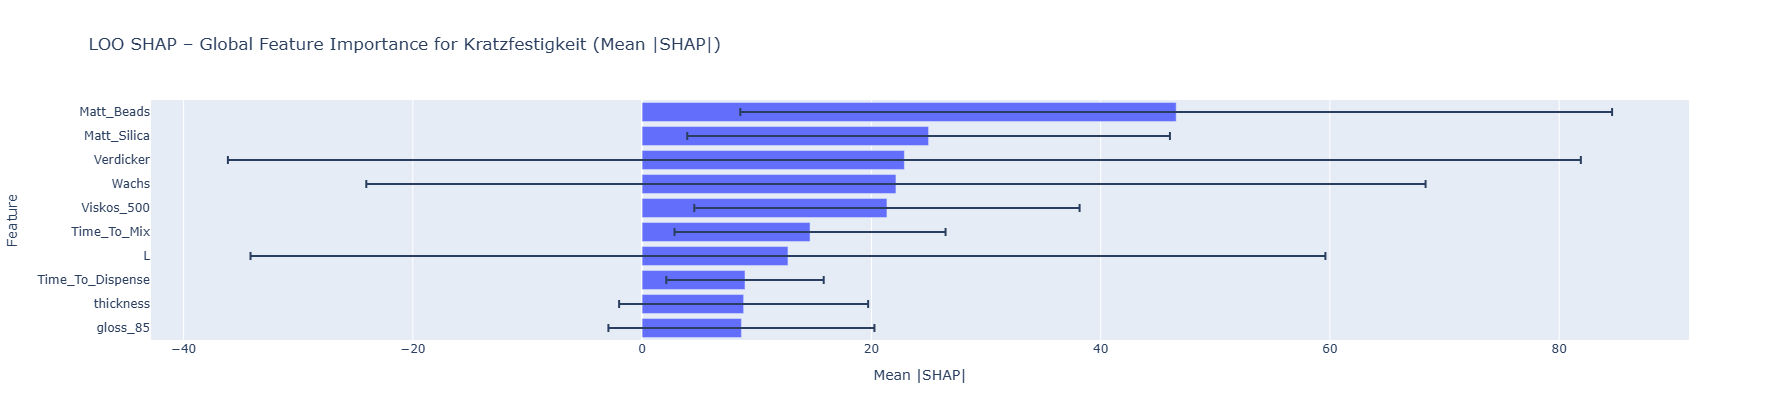

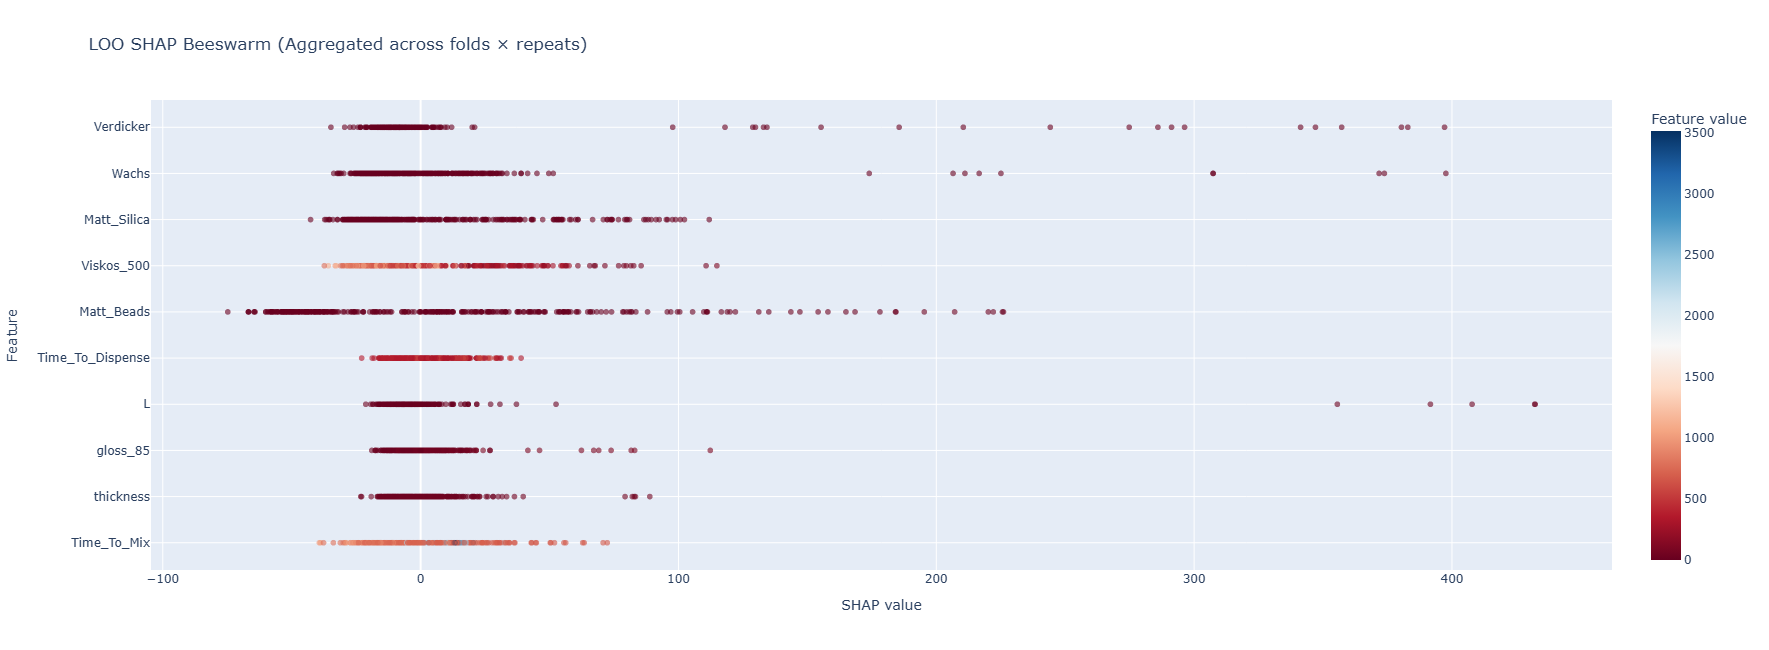

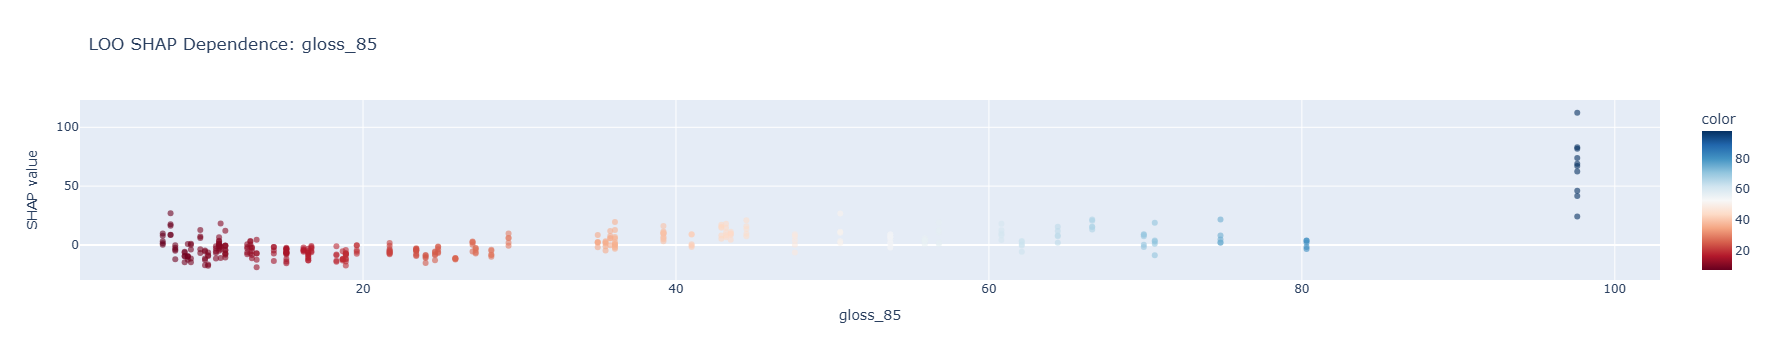

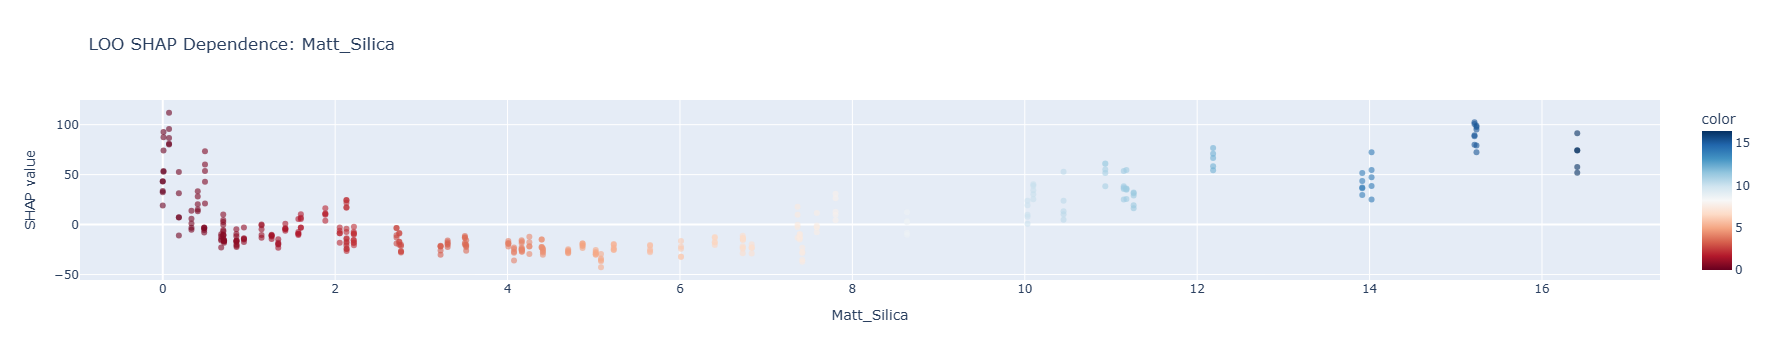

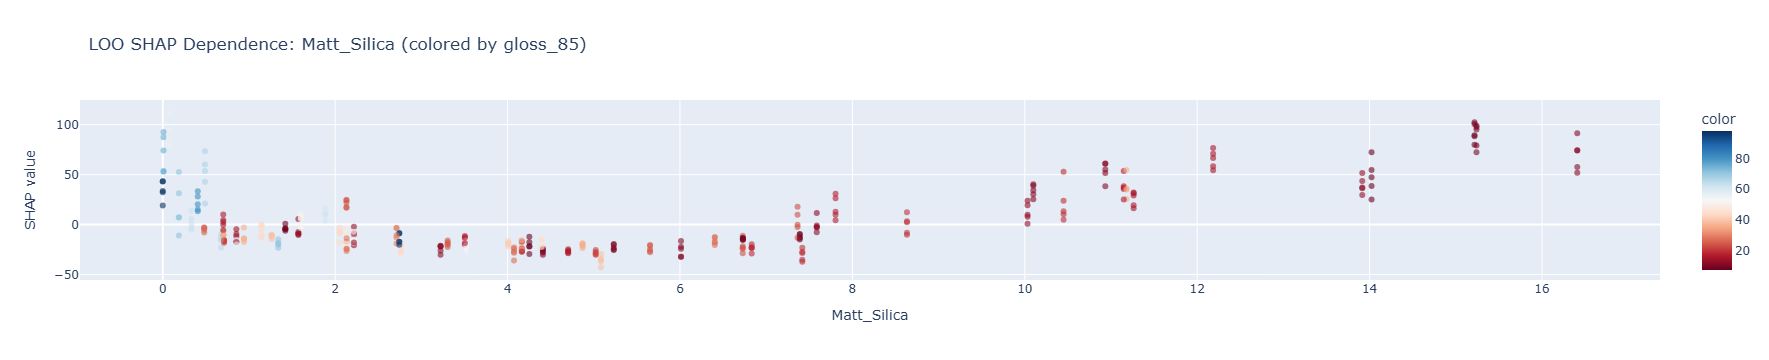

In [18]:
import shap
from sklearn.model_selection import LeaveOneOut
all_data = pd.read_csv("DoE_data.csv")
features = ["Matt_Beads", "Matt_Silica", 'Wachs', 'Verdicker','Time_To_Mix', 'Time_To_Dispense', 'thickness', "L", "Viskos_500", "gloss_85"]
X_all_unscaled = all_data[features].to_numpy()
y_all = all_data[targets].to_numpy().ravel()

# ========= LOO settings =========
n_repeats = 5   # increase if you want more smoothing over RF randomness

loo = LeaveOneOut()
all_shap_values = []               # (n_folds * n_repeats, n_features)
all_feature_values_unscaled = []   # matching rows for plotting
preds_all = []                     # predictions for left-out samples
truth_all = []                     # true y for left-out samples

for rep in range(n_repeats):
    print(f"Repeat {rep+1}/{n_repeats}")
    for train_idx, test_idx in loo.split(X_all_unscaled):
        X_tr_unscaled = X_all_unscaled[train_idx]
        y_tr = y_all[train_idx]
        X_lo_unscaled = X_all_unscaled[test_idx]  # shape (1, n_features)
        y_lo = y_all[test_idx]                    # shape (1,)

        # Scale for the model (RF doesn't need it, but harmless/consistent)
        scaler_X = MinMaxScaler().fit(X_tr_unscaled)
        X_tr = scaler_X.transform(X_tr_unscaled)
        X_lo = scaler_X.transform(X_lo_unscaled)

        # Train model (no random_state to keep randomness)
        model = RandomForestRegressor()
        model.fit(X_tr, y_tr)

        # Predict the left-out point
        y_pred_lo = model.predict(X_lo)
        preds_all.append(y_pred_lo[0])
        truth_all.append(y_lo[0])

        # SHAP for the left-out point using train as background
        explainer = shap.Explainer(model, X_tr)
        sv = explainer(X_lo, check_additivity=False)  # <- added flag
        all_shap_values.append(sv.values[0])  # store 1D: (n_features,)
        all_feature_values_unscaled.append(X_lo_unscaled[0])

# ========= Aggregate =========
shap_values_all = np.vstack(all_shap_values)                # (n_folds*n_repeats, n_features)
X_vis_unscaled  = np.vstack(all_feature_values_unscaled)    # (n_folds*n_repeats, n_features)
feature_names = features

# LOO metrics (over repeats * folds)
preds_all = np.array(preds_all)
truth_all = np.array(truth_all)

R2 = r2_score(truth_all, preds_all)
MSE = mean_squared_error(truth_all, preds_all)
MAE = mean_absolute_error(truth_all, preds_all)
MAE_mean = MAE / np.mean(np.abs(truth_all))
print("\n=== LOO performance on df_train (left-out predictions) ===")
print(f"R2: {R2:.4f} | MSE: {MSE:.4f} | MAE: {MAE:.4f} | MAE/Mean: {MAE_mean:.4f}")

# Global SHAP importance (mean |SHAP|) with std
mean_abs_shap = np.abs(shap_values_all).mean(axis=0)
std_abs_shap  = np.abs(shap_values_all).std(axis=0)
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Mean_Abs_SHAP": mean_abs_shap,
    "Std_Abs_SHAP": std_abs_shap
}).sort_values("Mean_Abs_SHAP", ascending=False)

# ========= Plots =========
# 1) Global bar (mean |SHAP|)
fig = px.bar(
    importance_df, x="Mean_Abs_SHAP", y="Feature",
    error_x="Std_Abs_SHAP", orientation="h",
    title="LOO SHAP – Global Feature Importance for Kratzfestigkeit (Mean |SHAP|)",
    labels={"Mean_Abs_SHAP": "Mean |SHAP|", "Std_Abs_SHAP": "Std |SHAP|"},
    height=420
)
fig.update_layout(yaxis=dict(categoryorder="total ascending"))
fig.show()

# 2) Beeswarm-like scatter (aggregated; color by actual unscaled value)
shap_df = pd.DataFrame(shap_values_all, columns=feature_names)
X_df = pd.DataFrame(X_vis_unscaled, columns=feature_names)

long_df = pd.concat([
    pd.melt(X_df, var_name="Feature", value_name="Feature_Value"),
    pd.melt(shap_df, var_name="Feature", value_name="SHAP_Value")["SHAP_Value"]
], axis=1)

fig2 = px.scatter(
    long_df, x="SHAP_Value", y="Feature", color="Feature_Value",
    color_continuous_scale="RdBu",
    title="LOO SHAP Beeswarm (Aggregated across folds × repeats)",
    labels={"SHAP_Value": "SHAP value", "Feature_Value": "Feature value"},
    height=650
)
fig2.update_traces(marker=dict(size=6, opacity=0.6))
fig2.update_layout(yaxis=dict(categoryorder="total ascending"))
fig2.show()

# 3) Dependence helper (uses unscaled values on x/color)
def plot_dependence(feature, color_by=None):
    fig = px.scatter(
        x=X_df[feature],
        y=shap_df[feature],
        color=X_df[color_by] if color_by else X_df[feature],
        color_continuous_scale="RdBu",
        labels={"x": feature, "y": "SHAP value"},
        title=f"LOO SHAP Dependence: {feature}" + (f" (colored by {color_by})" if color_by else "")
    )
    fig.update_traces(marker=dict(size=6, opacity=0.6))
    fig.show()

# Examples
plot_dependence("gloss_85")
plot_dependence("Matt_Silica")
plot_dependence("Matt_Silica", color_by="gloss_85")

# **LOO SHAP Insights for Kratzfestigkeit**
## **Global Feature Importance**
- **`gloss_85` dominates** the prediction landscape, with mean |SHAP| about 2–3× higher than the next feature.
- **Secondary contributors**: `Matt_Silica`, `L`, and `Time_To_Mix` still have meaningful influence.
- **Minimal impact** from `Viskos_500`, `Wachs`, `Verdicker`, and `Matt_Beads`.
## **Feature Effects & Patterns**
### **1. `gloss_85`**
- Strong **nonlinear relationship**:
  - **Low gloss (<20)** → strongly negative SHAP (hurts predicted scratch resistance).
  - **Mid gloss (30–50)** → peak positive SHAP (boosts predictions).
  - **High gloss (>70)** → still positive, but weaker.
- Suggests **threshold-like behavior** where mid-gloss optimizes scratch resistance.
### **2. `Matt_Silica`**
- **Low silica (~0–2)** → positive SHAP, boosting predictions.
- **Moderate silica (~4–8)** → SHAP drops toward zero.
- **High silica (>10)** → negative SHAP, suggesting excess silica harms predictions.
- **Interaction with gloss**: 
  - High gloss + low silica → positive SHAP.
  - Low gloss + high silica → negative SHAP.
### **3. Process Variables**
- `L` and `Time_To_Mix` both contribute positively in certain ranges, reinforcing their role from earlier findings.
- Effects are smaller than gloss and silica but still non-negligible.

---

## **Overall Takeaways**
- **`gloss_85` is the single most critical predictor** for `Kratzfestigkeit` in the LOO framework.
- **Silica’s impact is highly dependent on gloss level**, confirming the interaction seen in earlier analysis.
- **Process variables** still matter, though their effect size is smaller than optical properties.
- Results are consistent with previous assessments: scratch resistance is driven by a combination of surface finish (`gloss_85`), formulation content (`Matt_Silica`), and processing conditions.

# Compare Polynomial features and interactions of `gloss_85` & `Matt_Silica`

In [19]:
all_data = pd.read_csv("DoE_data.csv")
df_train = all_data[all_data["split"] == "train"]
df_test = all_data[all_data["split"] == "test"]

# ==== Add engineered features to train and test ====
for df in [df_train, df_test]:
    df["gloss_85_squared"] = df["gloss_85"] ** 2
    df["matt_silica_squared"] = df["Matt_Silica"] ** 2
    df["gloss_85_x_matt_silica"] = df["gloss_85"] * df["Matt_Silica"]

# ==== Feature set configurations ====
feature_sets = {
    "Config 1": ["Matt_Beads", "Matt_Silica", 'Wachs', 'Verdicker','Time_To_Mix', 'Time_To_Dispense', 'thickness', "L", "Viskos_500", "gloss_85"],

    "Config 2": ["Matt_Beads", "Matt_Silica", 'Wachs', 'Verdicker','Time_To_Mix', 'Time_To_Dispense', 'thickness', "L","Viskos_500", "gloss_85",
                 "gloss_85_squared", "matt_silica_squared"],

    "Config 3": ["Matt_Beads", "Matt_Silica", 'Wachs', 'Verdicker', 'Time_To_Mix', 'Time_To_Dispense', 'thickness', "L","Viskos_500", "gloss_85",
                 "gloss_85_x_matt_silica"],

    "Config 4": ["Matt_Beads", "Matt_Silica", 'Wachs', 'Verdicker','Time_To_Mix', 'Time_To_Dispense', 'thickness', "L","Viskos_500", "gloss_85",
                 "gloss_85_squared", "matt_silica_squared", "gloss_85_x_matt_silica"]
}

# ==== Parameters ====
n_trials = 100
all_results = []

# ==== Main evaluation loop ====
for config_name, selected_train_columns in feature_sets.items():
    print(f"\n=== Running {config_name} ===")
    
    X_train = np.array(df_train[selected_train_columns])
    y_train = np.array(df_train[selected_target_columns])
    X_test = np.array(df_test[selected_train_columns])
    y_test = np.array(df_test[selected_target_columns])
    
    # Scale features
    scaler = MinMaxScaler((0, 1))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    for i, target in enumerate(selected_target_columns):
        print(f"  Target: {target}")
        
        mse_list, mae_list, mae_mean_ratio_list, r2_list = [], [], [], []
        
        for _ in range(n_trials):
            rf = RandomForestRegressor(
                n_estimators=200, 
                max_depth=None, 
                min_samples_split=2
            )
            rf.fit(X_train_scaled, y_train[:, i])
            y_pred_target = rf.predict(X_test_scaled)
            
            mse_list.append(mean_squared_error(y_test[:, i], y_pred_target))
            mae_list.append(mean_absolute_error(y_test[:, i], y_pred_target))
            mae_mean_ratio_list.append(mae_list[-1] / np.mean(np.abs(y_test[:, i])))
            r2_list.append(r2_score(y_test[:, i], y_pred_target))
        
        all_results.append({
            "Config": config_name,
            "Target": target,
            "MSE_mean": np.mean(mse_list), "MSE_std": np.std(mse_list),
            "MAE_mean": np.mean(mae_list), "MAE_std": np.std(mae_list),
            "MAE/Mean_mean": np.mean(mae_mean_ratio_list), "MAE/Mean_std": np.std(mae_mean_ratio_list),
            "R2_mean": np.mean(r2_list), "R2_std": np.std(r2_list)
        })

# ==== Combine results into DataFrame for comparison ====
results_df = pd.DataFrame(all_results)
results_pivot = results_df.pivot(index="Target", columns="Config", values="R2_mean")

print("\n=== R² Mean Comparison ===")
display(results_pivot)

/tmp/ipykernel_471585/1482819978.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_471585/1482819978.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_471585/1482819978.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykerne


=== Running Config 1 ===
  Target: Kratzfestigkeit

=== Running Config 2 ===
  Target: Kratzfestigkeit

=== Running Config 3 ===
  Target: Kratzfestigkeit

=== Running Config 4 ===
  Target: Kratzfestigkeit

=== R² Mean Comparison ===


Config,Config 1,Config 2,Config 3,Config 4
Target,,,,
Kratzfestigkeit,0.321635,0.312395,0.30156,0.303475


In [20]:
from sklearn.linear_model import LinearRegression
# === Feature engineering ===
for df in [df_train, df_test]:
    df["gloss_85_squared"] = df["gloss_85"] ** 2
    df["matt_silica_squared"] = df["Matt_Silica"] ** 2
    df["gloss_85_x_matt_silica"] = df["gloss_85"] * df["Matt_Silica"]

# === Configurations ===
base_feats = ["Matt_Beads", "Matt_Silica", 'Wachs', 'Verdicker',
              'Time_To_Mix', 'Time_To_Dispense', 'thickness', "L", 
              "Viskos_500", "gloss_85"]

configs = {
    "A_base": base_feats,
    "B_poly": base_feats + ["gloss_85_squared", "matt_silica_squared"],
    "C_inter": base_feats + ["gloss_85_x_matt_silica"],
    "D_full": base_feats + ["gloss_85_squared", "matt_silica_squared", "gloss_85_x_matt_silica"]
}

target = "Kratzfestigkeit"
results = []

# === Evaluate ===
for name, feats in configs.items():
    X_train = df_train[feats].to_numpy()
    X_test = df_test[feats].to_numpy()
    y_train = df_train[target].to_numpy()
    y_test = df_test[target].to_numpy()
    
    # Standardize (important for linear regression)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    results.append({
        "Config": name,
        "R2": r2_score(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred)
    })

# === Show results ===
results_df = pd.DataFrame(results)
print(results_df.sort_values("R2", ascending=False))

    Config        R2       MSE       MAE
0   A_base -2.477368  2.825301  1.542927
2  C_inter -2.701661  3.007535  1.595555
1   B_poly -3.547888  3.695080  1.788023
3   D_full -3.827954  3.922629  1.841165


/tmp/ipykernel_471585/2775388615.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_471585/2775388615.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_471585/2775388615.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Insights
- All configs are performing terribly in a simple linear model (negative R² means worse than just predicting the mean).

Adding the gloss_85 × Matt_Silica interaction (Config C) or the squared terms (Configs B and D) did not help — if anything, they hurt performance slightly.

This suggests that the non-linear pattern you saw in SHAP is not well captured by a single multiplicative term or a simple quadratic.

The relationship is likely more complex — for example, piecewise, threshold-based, or involving multiple variables at once — which is why RandomForest was able to pick it up but linear regression fails.

So:
✅ Interaction exists in the flexible model.
❌ It doesn’t translate into a simple parametric feature that helps a linear model on your small dataset.

If you want to confirm the SHAP-based interaction is real and not noise, the next step would be a permutation-based interaction strength test (like shap.interaction_values for tree models) or partial dependence surface plots.

# Leave-One-out-Cross-Validation

In [21]:
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.neighbors import KNeighborsRegressor
import sys
import warnings
from collections import Counter
import os 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

# === Model Configuration ===
models = {
    'RandomForest': {
        'estimator': RandomForestRegressor(),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, None],
            'min_samples_split': [2, 5]
        }
    },
    'XGBoost': {
        'estimator': XGBRegressor(objective='reg:squarederror', verbosity=0),
        'param_grid': {
            'n_estimators': [50, 100],
            'max_depth': [3, 4, 5],
            'learning_rate': [0.05, 0.1]
        }
    },
    'KNN': {
        'estimator': KNeighborsRegressor(),
        'param_grid': {
            'n_neighbors': [1, 3, 5, 7],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    },
    'GP': {
        'estimator': GaussianProcessRegressor(normalize_y=True),
        'param_grid': {
            'kernel': [
                C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)),
                C(0.5, (1e-3, 1e3)) * RBF(length_scale=0.5, length_scale_bounds=(1e-2, 1e2)),
            ],
            'alpha': [1e-10, 1e-5, 1e-2]
        }
    }
}

# === Data Load ===
all_data = pd.read_csv("DoE_data.csv")
df_train = all_data[all_data["split"] == "train"]
df_test = all_data[all_data["split"] == "test"]
selected_train_columns = [
    "Matt_Beads", "Matt_Silica", 'Wachs', 'Verdicker',
    'Time_To_Mix', 'Time_To_Dispense', 'thickness',
    "L", "Viskos_500", "gloss_85"
]
target = "Kratzfestigkeit"

# === Data Preparation ===
X_full = all_data[selected_train_columns].values
y_full = all_data[[target]].values  # no scaling

n_samples = X_full.shape[0]

scaler_X = MinMaxScaler()
X_full_scaled = scaler_X.fit_transform(X_full)

X_scaled_df = pd.DataFrame(X_full_scaled, columns=[f"{col}_scaled" for col in selected_train_columns])
X_scaled_df.insert(0, "Sample_Index", range(n_samples))

print(f"\n🔍 LOOCV for Target: {target}")

# === LOOCV Function ===
def run_loocv(model_name, estimator, param_grid):
    print(f"\n📌 Running LOOCV for: {model_name}")
    results = {
        "Sample_Index": [], f"{target}_True": [], f"{target}_Pred": [],
        f"{target}_Abs_Error": []
    }

    for i in range(n_samples):
        X_loo_train = np.delete(X_full_scaled, i, axis=0)
        y_loo_train = np.delete(y_full, i, axis=0).ravel()
        X_val = X_full_scaled[i].reshape(1, -1)
        y_val = y_full[i].item()

        grid_search = GridSearchCV(
            estimator=estimator,
            param_grid=param_grid,
            cv=3,
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )
        grid_search.fit(X_loo_train, y_loo_train)
        best_model = grid_search.best_estimator_

        y_pred = best_model.predict(X_val).item()

        results["Sample_Index"].append(i)
        results[f"{target}_True"].append(y_val)
        results[f"{target}_Pred"].append(y_pred)
        results[f"{target}_Abs_Error"].append(abs(y_pred - y_val))

    result_df = pd.DataFrame(results)
    result_df = pd.merge(result_df, X_scaled_df, on="Sample_Index", how="left")
    result_df = result_df.sort_values(f"{target}_Abs_Error", ascending=False)
    return result_df

# === Run All Models ===
result_df_rf = run_loocv("RandomForest", models['RandomForest']['estimator'], models['RandomForest']['param_grid'])
result_df_xgb = run_loocv("XGBoost", models['XGBoost']['estimator'], models['XGBoost']['param_grid'])
result_df_knn = run_loocv("KNN", models['KNN']['estimator'], models['KNN']['param_grid'])
result_df_gp = run_loocv("GP", models['GP']['estimator'], models['GP']['param_grid'])

# === Display Top Errors ===
for model_name, result_df in zip(["RandomForest", "XGBoost", "KNN", "GP"],
                                 [result_df_rf, result_df_xgb, result_df_knn, result_df_gp]):
    print(f"\n📊 Top 5 Absolute Errors - {model_name}")
    display(result_df[[
        f'{target}_True', f'{target}_Pred', f'{target}_Abs_Error'
    ]].head(5))


🔍 LOOCV for Target: Kratzfestigkeit

📌 Running LOOCV for: RandomForest

📌 Running LOOCV for: XGBoost

📌 Running LOOCV for: KNN

📌 Running LOOCV for: GP

📊 Top 5 Absolute Errors - RandomForest


,Kratzfestigkeit_True,Kratzfestigkeit_Pred,Kratzfestigkeit_Abs_Error
67,2.966667,1.604833,1.361833
47,0.800000,2.074460,1.274460
24,2.733333,1.519270,1.214063
44,0.833333,1.797363,0.964029
39,1.300000,2.259231,0.959231



📊 Top 5 Absolute Errors - XGBoost


,Kratzfestigkeit_True,Kratzfestigkeit_Pred,Kratzfestigkeit_Abs_Error
47,0.800000,2.121195,1.321195
24,2.733333,1.620252,1.113081
63,2.166667,1.170626,0.996041
67,2.966667,2.024165,0.942501
35,1.366667,2.273665,0.906998



📊 Top 5 Absolute Errors - KNN


,Kratzfestigkeit_True,Kratzfestigkeit_Pred,Kratzfestigkeit_Abs_Error
67,2.966667,1.353410,1.613257
68,2.666667,1.137939,1.528728
3,2.966667,1.466667,1.500000
47,0.800000,2.206402,1.406402
4,2.666667,1.629341,1.037326



📊 Top 5 Absolute Errors - GP


,Kratzfestigkeit_True,Kratzfestigkeit_Pred,Kratzfestigkeit_Abs_Error
68,2.666667,0.970641,1.696026
23,2.333333,0.898733,1.434601
67,2.966667,1.607402,1.359265
15,2.600000,1.378287,1.221713
47,0.800000,2.015664,1.215664


# bootstrap high values of kratzfestigkeit in the training set

In [22]:
# === Load and split data ===
all_data = pd.read_csv('./DoE_data.csv', delimiter=",")
df_train = all_data[all_data["split"] == "train"].copy()
df_test = all_data[all_data["split"] == "test"].copy()

target = "Kratzfestigkeit"
selected_train_columns = [
    "Matt_Beads", "Matt_Silica", 'Wachs', 'Verdicker',
    'Time_To_Mix', 'Time_To_Dispense', 'thickness',
    "L", "Viskos_500", "gloss_85"
]
selected_target_columns = [target]

# === Config ===
FACTOR_EXTRA = 5  # number of extra copies (so total = original + FACTOR_EXTRA if keeping originals)
KEEP_ORIGINAL_SELECTED = False  # False -> replace selected originals

# === Identify 3 samples with the highest Kratzfestigkeit in train set ===
df_train[target] = df_train[target].astype(float)
highest_kratz_indices = df_train.nlargest(3, target).index.tolist()
print(f"🔥 Highest Kratzfestigkeit sample indices: {highest_kratz_indices}")
display(df_train.loc[highest_kratz_indices, [target] + selected_train_columns])

SELECTED_IDX = highest_kratz_indices

# === Build bootstrapped train_df ===
# 1) Start from train originals
base = df_train[selected_train_columns + selected_target_columns].copy()
base.insert(0, "Original_Index", df_train.index)
base["Source"] = "original"

# 2) Optionally drop selected originals (for replace behavior)
if not KEEP_ORIGINAL_SELECTED:
    base = base[~base["Original_Index"].isin(SELECTED_IDX)]

# 3) Build exactly FACTOR_EXTRA duplicates for each selected index
boot_blocks = []
for idx in SELECTED_IDX:
    if idx not in df_train.index:
        raise IndexError(f"Index {idx} not in df_train.index")

    row = df_train.loc[[idx], selected_train_columns + selected_target_columns].copy()
    row.insert(0, "Original_Index", [idx])
    row["Source"] = "bootstrapped_high"

    # Repeat FACTOR_EXTRA times (only extras)
    boot_block = pd.DataFrame(np.repeat(row.values, FACTOR_EXTRA, axis=0), columns=row.columns)
    boot_blocks.append(boot_block)

boot = pd.concat(boot_blocks, axis=0) if boot_blocks else pd.DataFrame(columns=base.columns)

# 4) Combine and check size
bootstrapped_train_df_high = pd.concat([base, boot], axis=0).reset_index(drop=True)

# === Sanity checks ===
counts = Counter(bootstrapped_train_df_high["Original_Index"])
expected_total = (len(df_train) - (0 if KEEP_ORIGINAL_SELECTED else len(SELECTED_IDX))) \
                 + FACTOR_EXTRA * len(SELECTED_IDX)
actual_total = len(bootstrapped_train_df_high)

print(f"Expected rows: {expected_total} | Actual rows: {actual_total}")
assert expected_total == actual_total, "Row count mismatch!"

for idx in SELECTED_IDX:
    expected = (1 if KEEP_ORIGINAL_SELECTED else 0) + FACTOR_EXTRA
    assert counts[idx] == expected, f"Index {idx} occurs {counts[idx]}, expected {expected}"

🔥 Highest Kratzfestigkeit sample indices: [3, 16, 24]


,Kratzfestigkeit,Matt_Beads,Matt_Silica,Wachs,Verdicker,Time_To_Mix,Time_To_Dispense,thickness,L,Viskos_500,gloss_85
3,2.966667,3.762,1.263,2.993,3.758,1105.0,321.0,36.24,8.86,979.062,39.2
16,2.733333,1.225,0.678,1.877,2.350,1141.0,317.0,36.08,6.35,704.638,64.4
24,2.733333,2.628,0.490,0.641,2.682,686.0,349.0,34.40,6.25,799.539,66.6


Expected rows: 76 | Actual rows: 76


### check performance gain

In [23]:
# === Load original and bootstrapped training sets ===
all_data = pd.read_csv("DoE_data.csv")
df_train_original = all_data[all_data["split"] == "train"].copy()
df_test = all_data[all_data["split"] == "test"].copy()

# === Config ===
n_trials = 100
all_results = []

# === Evaluation function ===
def evaluate_config(config_name, df_train, df_test, n_trials=100):
    print(config_name)
    X_train = df_train[selected_train_columns].values
    y_train = df_train[selected_target_columns].values
    X_test = df_test[selected_train_columns].values
    y_test = df_test[selected_target_columns].values
    
    # Scale features
    scaler = MinMaxScaler((0, 1))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    mse_list, mae_list, mae_mean_ratio_list, r2_list = [], [], [], []
    
    for _ in range(n_trials):
        rf = RandomForestRegressor(
            n_estimators=200,
            max_depth=None,
            min_samples_split=2,
            random_state=None
        )
        rf.fit(X_train_scaled, y_train.ravel())
        y_pred_target = rf.predict(X_test_scaled)
        
        mse_list.append(mean_squared_error(y_test.ravel(), y_pred_target))
        mae_list.append(mean_absolute_error(y_test.ravel(), y_pred_target))
        mae_mean_ratio_list.append(mae_list[-1] / np.mean(np.abs(y_test.ravel())))
        r2_list.append(r2_score(y_test.ravel(), y_pred_target))
    
    return {
        "Config": config_name,
        "Target": target,
        "MSE_mean": np.mean(mse_list), "MSE_std": np.std(mse_list),
        "MAE_mean": np.mean(mae_list), "MAE_std": np.std(mae_list),
        "MAE/Mean_mean": np.mean(mae_mean_ratio_list), "MAE/Mean_std": np.std(mae_mean_ratio_list),
        "R2_mean": np.mean(r2_list), "R2_std": np.std(r2_list)
    }

# === Run for original and bootstrapped ===
all_results.append(evaluate_config("Original Train", df_train_original, df_test, n_trials))
all_results.append(evaluate_config("Bootstrapped Train", bootstrapped_train_df_high, df_test, n_trials))

# === Display results ===
results_df = pd.DataFrame(all_results)
print("\n=== Metrics Comparison ===")
display(results_df[[
    "Config", "MSE_mean", "MSE_std", "MAE_mean", "MAE_std",
    "MAE/Mean_mean", "MAE/Mean_std", "R2_mean", "R2_std"
]])

Original Train
Bootstrapped Train

=== Metrics Comparison ===


,Config,MSE_mean,MSE_std,MAE_mean,MAE_std,MAE/Mean_mean,MAE/Mean_std,R2_mean,R2_std
0,Original Train,0.557424,0.020978,0.576760,0.011989,0.335163,0.006967,0.313925,0.025820
1,Bootstrapped Train,0.392700,0.017837,0.537791,0.011877,0.312518,0.006902,0.516666,0.021953


## bootstrap lowest values of kratzfestigkeit in the training set

In [24]:
# === Identify 3 samples with the lowest Kratzfestigkeit in train set ===
lowest_kratz_indices = df_train.nsmallest(3, target).index.tolist()
print(f"❄️ Lowest Kratzfestigkeit sample indices: {lowest_kratz_indices}")
display(df_train.loc[lowest_kratz_indices, [target] + selected_train_columns])

# === Build bootstraps for lowest values ===
boot_blocks_low = []
for idx in lowest_kratz_indices:
    if idx not in df_train.index:
        raise IndexError(f"Index {idx} not in df_train.index")

    row = df_train.loc[[idx], selected_train_columns + selected_target_columns].copy()
    row.insert(0, "Original_Index", [idx])
    row["Source"] = "bootstrapped_low"

    # Repeat FACTOR_EXTRA times (only extras)
    boot_block = pd.DataFrame(np.repeat(row.values, FACTOR_EXTRA, axis=0), columns=row.columns)
    boot_blocks_low.append(boot_block)

boot_low = pd.concat(boot_blocks_low, axis=0) if boot_blocks_low else pd.DataFrame(columns=bootstrapped_train_df.columns)

# === Combine with the already bootstrapped dataset from highs ===
bootstrapped_train_df_high_low = pd.concat([bootstrapped_train_df_high, boot_low], axis=0).reset_index(drop=True)

# === Sanity check ===
from collections import Counter
counts = Counter(bootstrapped_train_df_high_low["Original_Index"])

# Calculate expected total: after highs + lows
rows_after_highs = (len(df_train) - len(highest_kratz_indices)) + FACTOR_EXTRA * len(highest_kratz_indices)
rows_after_lows = rows_after_highs + FACTOR_EXTRA * len(lowest_kratz_indices)

print(f"Expected rows after highs + lows: {rows_after_lows} | Actual rows: {len(bootstrapped_train_df_high_low)}")
assert rows_after_lows == len(bootstrapped_train_df_high_low), "Row count mismatch after adding lows!"

# Check individual counts for lows (they still had their original, so expect 1 original + extras)
for idx in lowest_kratz_indices:
    expected = 1 + FACTOR_EXTRA
    assert counts[idx] == expected, f"Index {idx} occurs {counts[idx]}, expected {expected}"

print("✅ Bootstrapped training dataset now contains both highest and lowest 3 Kratzfestigkeit rows.")

❄️ Lowest Kratzfestigkeit sample indices: [53, 5, 58]


,Kratzfestigkeit,Matt_Beads,Matt_Silica,Wachs,Verdicker,Time_To_Mix,Time_To_Dispense,thickness,L,Viskos_500,gloss_85
53,0.166667,5.079,14.023,3.457,4.624,742.0,319.0,33.36,20.56,770.6100,7.2
5,0.466667,6.545,10.934,3.494,0.647,948.0,318.0,33.76,18.68,92.5222,10.8
58,0.533333,1.392,16.409,0.711,2.440,698.0,355.0,34.72,17.74,287.1390,10.9


Expected rows after highs + lows: 91 | Actual rows: 91
✅ Bootstrapped training dataset now contains both highest and lowest 3 Kratzfestigkeit rows.


### check performance gain

In [25]:
# === Load original and bootstrapped training sets ===
all_data = pd.read_csv("DoE_data.csv")
df_train_original = all_data[all_data["split"] == "train"].copy()
df_test = all_data[all_data["split"] == "test"].copy()
print(len(bootstrapped_train_df_high))
print(len(bootstrapped_train_df_high_low))
# === Config ===
n_trials = 100
all_results = []

# === Evaluation function ===
def evaluate_config(config_name, df_train, df_test, n_trials=100):
    print(config_name)
    X_train = df_train[selected_train_columns].values
    y_train = df_train[selected_target_columns].values
    X_test = df_test[selected_train_columns].values
    y_test = df_test[selected_target_columns].values
    
    # Scale features
    scaler = MinMaxScaler((0, 1))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    mse_list, mae_list, mae_mean_ratio_list, r2_list = [], [], [], []
    
    for _ in range(n_trials):
        rf = RandomForestRegressor(
            n_estimators=200,
            max_depth=None,
            min_samples_split=2,
            random_state=None
        )
        rf.fit(X_train_scaled, y_train.ravel())
        y_pred_target = rf.predict(X_test_scaled)
        
        mse_list.append(mean_squared_error(y_test.ravel(), y_pred_target))
        mae_list.append(mean_absolute_error(y_test.ravel(), y_pred_target))
        mae_mean_ratio_list.append(mae_list[-1] / np.mean(np.abs(y_test.ravel())))
        r2_list.append(r2_score(y_test.ravel(), y_pred_target))
    
    return {
        "Config": config_name,
        "Target": target,
        "MSE_mean": np.mean(mse_list), "MSE_std": np.std(mse_list),
        "MAE_mean": np.mean(mae_list), "MAE_std": np.std(mae_list),
        "MAE/Mean_mean": np.mean(mae_mean_ratio_list), "MAE/Mean_std": np.std(mae_mean_ratio_list),
        "R2_mean": np.mean(r2_list), "R2_std": np.std(r2_list)
    }

# === Run for original and bootstrapped ===
all_results.append(evaluate_config("Original Train", df_train_original, df_test, n_trials))
all_results.append(evaluate_config("Bootstrapped High", bootstrapped_train_df_high, df_test, n_trials))
all_results.append(evaluate_config("Bootstrapped High+Low", bootstrapped_train_df_high_low, df_test, n_trials))

# === Display results ===
results_df = pd.DataFrame(all_results)
print("\n=== Metrics Comparison ===")
display(results_df[[
    "Config", "MSE_mean", "MSE_std", "MAE_mean", "MAE_std",
    "MAE/Mean_mean", "MAE/Mean_std", "R2_mean", "R2_std"
]])

76
91
Original Train
Bootstrapped High
Bootstrapped High+Low

=== Metrics Comparison ===


,Config,MSE_mean,MSE_std,MAE_mean,MAE_std,MAE/Mean_mean,MAE/Mean_std,R2_mean,R2_std
0,Original Train,0.555609,0.021833,0.576022,0.011844,0.334735,0.006883,0.316159,0.026872
1,Bootstrapped High,0.392872,0.018679,0.538651,0.012953,0.313018,0.007527,0.516455,0.022990
2,Bootstrapped High+Low,0.433286,0.018965,0.539692,0.011972,0.313622,0.006957,0.466713,0.023342


In [26]:
# === Sort and save ===
sorted_bootstrapped_train_df = bootstrapped_train_df_high_low.sort_values(
    by=["Source", "Original_Index"],
    ascending=[False, True]
).reset_index(drop=True)

sorted_bootstrapped_train_df.to_csv("bootstrapped_train_data.csv", index=False)
print("✅ Bootstrapped training dataset saved to 'bootstrapped_train_data.csv'")

✅ Bootstrapped training dataset saved to 'bootstrapped_train_data.csv'


<Axes: >

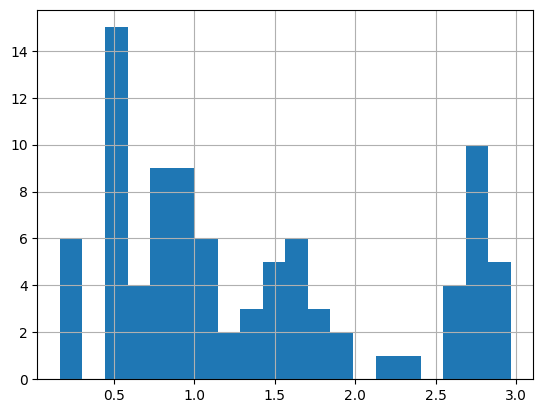

In [27]:
bootstrapped_train_df_high_low["Kratzfestigkeit"].hist(bins=20)